In [1]:
pip install torch

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install torchattacks

     |████████████████████████████████| 102 kB 1.2 MB/s           
Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install torchvision --upgrade

     |████████████████████████████████| 21.0 MB 922 kB/s            
     |████████████████████████████████| 750.6 MB 8.0 kB/s             
  Attempting uninstall: torch
    Found existing installation: torch 1.9.1
    Uninstalling torch-1.9.1:
      Successfully uninstalled torch-1.9.1
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.10.1
    Uninstalling torchvision-0.10.1:
      Successfully uninstalled torchvision-0.10.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
fastai 2.5.3 requires torch<1.11,>=1.7.0, but you have torch 1.11.0 which is incompatible.
allennlp 2.9.0 requires torch<1.11.0,>=1.6.0, but you have torch 1.11.0 which is incompatible.
allennlp 2.9.0 requires torchvision<0.12.0,>=0.8.1, but you have torchvision 0.12.0 which is incompatible.
Note: you may need to restart the kernel to use updated packages.


In [5]:
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [6]:
pip install torchsummary

Note: you may need to restart the kernel to use updated packages.


In [7]:
import numpy as np
import pandas as pd
import torch
from PIL import Image
from torch.utils.data import Dataset, DataLoader, random_split
import os
import os.path as osp
import matplotlib.pyplot as plt

In [10]:
import torchvision
import torchvision.transforms as T

In [11]:
df = pd.read_csv("../input/cancer-detection/train_labels.csv")
len(df)

220025

In [12]:
df[df.duplicated(keep=False)]
len(df)

220025

In [13]:
df['label'].value_counts()

0    130908
1     89117
Name: label, dtype: int64

## Custom Image Dataset

In [14]:
train_path = '../input/cancer-detection/train'
test_path = '../input/cancer-detection/test'

from sklearn.model_selection import train_test_split

train, val = train_test_split(df, 
                              stratify=df.label, 
                              test_size=0.2)

_, fgsm_train = train_test_split(train, stratify=train.label, test_size=0.3)

print("train size: ", len(train))
print("val size: ", len(val))
print("fgsm_train size: ", len(fgsm_train))

train size:  176020
val size:  44005
fgsm_train size:  52806


## 1. Normal ImageDataset

In [15]:
import cv2
import matplotlib.image as mpimg
from matplotlib.colors import Normalize

In [16]:
class ImageDataset(Dataset):
    def __init__(self, df, image_dir, transform=None, knn=False):
        super().__init__()
        self.df = df.values
        self.image_dir = image_dir
        self.transform = transform
        self.knn = knn
    
    def __getitem__(self, idx):
        img_name, label = self.df[idx]
        img_path = os.path.join(self.image_dir, img_name + '.tif')
        
        # image for knn classifier
        if self.knn is True:
            img = mpimg.imread(img_path)
            return img, label
            
        # Torch Tensor
        else:
            img = Image.open(img_path) # PIL image read
            img = self.transform(img)
        
        return img, label
    
    def __len__(self):
        return len(self.df)
        

In [17]:
def imshow(image, label, knn_bool=False):
    label = str(label)
    plt.figure(figsize=(2, 2))
    plt.title("label: " + label)
    
    # for PIL and Torch Tensor
    if knn_bool is False: 
        image = image.permute(1, 2, 0)
        plt.imshow(image)
        plt.show()
    
    # for KNN
    else:
        plt.imshow(image)
        plt.show()

In [18]:
class AddGaussianNoise(object):
    def __init__(self, mean=0, std=1.):
        self.std = std
        self.mean = mean
    
    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean
    
    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)

In [19]:
transform = T.Compose([T.Resize(96),
                       T.ToTensor(),
                       T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                      ])

transform_gaussian = T.Compose([T.Resize(96),
                       T.ToTensor(),
                       T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                       AddGaussianNoise(0., 1.)
                      ])

Train Size:  176020
Augmented Train Size:  352040


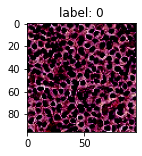

In [20]:
train_path = '../input/cancer-detection/train'

batch_train = 512
batch_val = 128

# Clean train image
train_img = ImageDataset(df=train, image_dir=train_path, transform=transform)                    
train_loader = DataLoader(dataset=train_img, batch_size=batch_train, shuffle=True)

# Noisy Image (for augmentation)
train_img_gaussian = ImageDataset(df=train, image_dir=train_path, transform=transform_gaussian)  # Only gaussian noise image
train_loader_gaussian = DataLoader(dataset=train_img_gaussian, batch_size=batch_train, shuffle=True)

# Clean validation image
val_img = ImageDataset(df=val, image_dir=train_path, transform=transform)
val_loader = DataLoader(dataset=val_img, batch_size=batch_val, shuffle=True)

# Noisy validation iamge
val_img_gaussian = ImageDataset(df=val, image_dir=train_path, transform=transform_gaussian)
val_loader_gaussian = DataLoader(dataset=val_img_gaussian, batch_size=batch_val, shuffle=True)

# Augmentation
train_img_augment = train_img + train_img_gaussian  # Augmented Train Dataset
train_loader_augment = DataLoader(dataset=train_img_augment, batch_size=batch_train, shuffle=True) # Augmented Train Dataloader

val_img_augment = val_img + val_img_gaussian        # Augmented Val Dataset
val_loader_augment = DataLoader(dataset=val_img_augment, batch_size=batch_val, shuffle=True)     # Augmented Val Dataloader

print("Train Size: ", len(train_img))
print("Augmented Train Size: ", len(train_img_augment))

image, label = val_img[202]
imshow(image, label) 

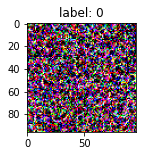

In [21]:
image, label = val_img_gaussian[202]
imshow(image, label)

## KNN Classification - Clean

In [22]:
# Training Data
X_train, y_train = iter(train_loader).next()
X_train_flat = (X_train.reshape(X_train.shape[0], 3 * 96 * 96))

# Validation Data
X_val, y_val = iter(val_loader).next()
X_val_flat = (X_val.reshape(X_val.shape[0], 3 * 96 * 96))

# Noisy Data
X_val_gaussian, y_val_gaussian = iter(val_loader_gaussian).next()
X_val_gaussian_flat = (X_val_gaussian.reshape(X_val_gaussian.shape[0], 3 * 96 * 96))

print(X_train_flat.shape)
print(y_train.shape)

print(X_val_flat.shape)
print(y_val.shape)

print(X_val_gaussian_flat.shape)
print(y_val_gaussian.shape)

torch.Size([512, 27648])
torch.Size([512])
torch.Size([128, 27648])
torch.Size([128])
torch.Size([128, 27648])
torch.Size([128])


In [23]:
from sklearn.neighbors import KNeighborsClassifier

model = KNeighborsClassifier(n_neighbors=2)

num_epochs = 5

# for epoch in range(num_epochs+1):
    
# Train with clean data
model.fit(X_train_flat, y_train)

# Prediction on clean data
prediction = model.predict(X_val_flat)

# Prediction on noisy data
prediction_robust = model.predict(X_val_gaussian_flat)

y_val_list = y_val.tolist()
y_val_gaussian_list = y_val_gaussian.tolist()

print("Train with clean data")
print("")

print ('Clean Accuracy: %f' % (np.mean(prediction == y_val_list)))
print ('Robust Accuracy: %f' % (np.mean(prediction_robust == y_val_list)))
print("")

Train with clean data

Clean Accuracy: 0.625000
Robust Accuracy: 0.500000



## SVM Training

In [24]:
from sklearn.svm import SVC

model = SVC(gamma='auto', kernel='rbf')

# Train with clean data
model.fit(X_train_flat, y_train)

accuracy = model.score(X_val_flat, y_val)
robust_accuracy = model.score(X_val_gaussian_flat, y_val_gaussian)

print("SVM Training")
print('Clearn Accuracy: {}'.format(accuracy))
print("Robust Accuracy: {}".format(robust_accuracy))

SVM Training
Clearn Accuracy: 0.7890625
Robust Accuracy: 0.5859375


## SVM Robust Training

In [25]:
# Train with Augmented Dataset

X_train_augment, y_train_augment = iter(train_loader_augment).next()
X_train_flat_augment = (X_train_augment.reshape(X_train_augment.shape[0], 3 * 96 * 96))

print(X_train_flat_augment.shape)
print(y_train_augment.shape)

torch.Size([512, 27648])
torch.Size([512])


In [26]:
from sklearn.svm import SVC

model = SVC(gamma='auto', kernel='rbf')

# Train with augmentation
model.fit(X_train_flat_augment, y_train_augment)

accuracy = model.score(X_val_flat, y_val)
robust_accuracy = model.score(X_val_gaussian_flat, y_val_gaussian)

print("SVM Robust Training")
print('Clearn Accuracy: {}'.format(accuracy))
print("Robust Accuracy: {}".format(robust_accuracy))
print("")

SVM Robust Training
Clearn Accuracy: 0.6875
Robust Accuracy: 0.578125



In [27]:
from sklearn.svm import SVC

model = SVC(gamma='auto', kernel='rbf')

# Train with just gaussian image
X_train_gaussian, y_train_gaussian = iter(train_loader_gaussian).next()
X_train_gaussian_flat = (X_train_gaussian.reshape(X_train_gaussian.shape[0], 3 * 96 * 96))

model.fit(X_train_gaussian_flat, y_train_gaussian)

accuracy = model.score(X_val_flat, y_val)
robust_accuracy = model.score(X_val_gaussian_flat, y_val_gaussian)

print("SVM Robust Training")
print('Clearn Accuracy: {}'.format(accuracy))
print("Robust Accuracy: {}".format(robust_accuracy))
print("")

SVM Robust Training
Clearn Accuracy: 0.40625
Robust Accuracy: 0.6015625



## KNN Classification - Robust Training

In [28]:
# Train with Augmented Dataset

X_train_augment, y_train_augment = iter(train_loader_augment).next()
X_train_flat_augment = (X_train_augment.reshape(X_train_augment.shape[0], 3 * 96 * 96))

print(X_train_flat.shape)
print(y_train_augment.shape)

torch.Size([512, 27648])
torch.Size([512])


In [29]:
from sklearn.neighbors import KNeighborsClassifier

model = KNeighborsClassifier(n_neighbors=2)

# Train with augmented data
model.fit(X_train_flat_augment, y_train_augment)

# Prediction on clean data
prediction = model.predict(X_val_flat)

# Prediction on noisy data
prediction_robust = model.predict(X_val_gaussian_flat)

y_val_list = y_val.tolist()
y_val_gaussian_list = y_val_gaussian.tolist()

print ("After Augmented Training")
print("")

print ('Clean Accuracy: %f' % (np.mean(prediction == y_val_list)))
print ('Robust Accuracy: %f' % (np.mean(prediction_robust == y_val_list)))

After Augmented Training

Clean Accuracy: 0.648438
Robust Accuracy: 0.484375


In [30]:
from sklearn.neighbors import KNeighborsClassifier

model = KNeighborsClassifier(n_neighbors=2)

# Train with just gaussian image
X_train_gaussian, y_train_gaussian = iter(train_loader_gaussian).next()
X_train_gaussian_flat = (X_train_gaussian.reshape(X_train_gaussian.shape[0], 3 * 96 * 96))

model.fit(X_train_gaussian_flat, y_train_gaussian)

accuracy = model.score(X_val_flat, y_val)
robust_accuracy = model.score(X_val_gaussian_flat, y_val_gaussian)

print("KNN Robust Training (just with gaussian noise)")
print('Clearn Accuracy: {}'.format(accuracy))
print("Robust Accuracy: {}".format(robust_accuracy))
print("")

SVM Robust Training
Clearn Accuracy: 0.640625
Robust Accuracy: 0.65625



## Resnet-18

In [31]:
import torchvision
resnet18 = torchvision.models.resnet18(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [32]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
resnet18.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [33]:
from torchsummary import summary
summary(resnet18.to(device), (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 16, 16]           9,408
       BatchNorm2d-2           [-1, 64, 16, 16]             128
              ReLU-3           [-1, 64, 16, 16]               0
         MaxPool2d-4             [-1, 64, 8, 8]               0
            Conv2d-5             [-1, 64, 8, 8]          36,864
       BatchNorm2d-6             [-1, 64, 8, 8]             128
              ReLU-7             [-1, 64, 8, 8]               0
            Conv2d-8             [-1, 64, 8, 8]          36,864
       BatchNorm2d-9             [-1, 64, 8, 8]             128
             ReLU-10             [-1, 64, 8, 8]               0
       BasicBlock-11             [-1, 64, 8, 8]               0
           Conv2d-12             [-1, 64, 8, 8]          36,864
      BatchNorm2d-13             [-1, 64, 8, 8]             128
             ReLU-14             [-1, 6

### Modified Resnet-18

In [34]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class modified_resnet18(nn.Module):
    def __init__(self):
        super(modified_resnet18, self).__init__()
        self.resnet18 = torchvision.models.resnet18(pretrained=True)
        
        for param in self.resnet18.parameters():
            param.requres_grad = False
            
        modified_fc = nn.Linear(in_features=512, out_features=2)
        self.resnet18.fc = modified_fc
    
    def forward(self, x):
        return self.resnet18(x)

In [35]:
summary(modified_resnet18().to(device), (3, 96, 96))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 48, 48]           9,408
       BatchNorm2d-2           [-1, 64, 48, 48]             128
              ReLU-3           [-1, 64, 48, 48]               0
         MaxPool2d-4           [-1, 64, 24, 24]               0
            Conv2d-5           [-1, 64, 24, 24]          36,864
       BatchNorm2d-6           [-1, 64, 24, 24]             128
              ReLU-7           [-1, 64, 24, 24]               0
            Conv2d-8           [-1, 64, 24, 24]          36,864
       BatchNorm2d-9           [-1, 64, 24, 24]             128
             ReLU-10           [-1, 64, 24, 24]               0
       BasicBlock-11           [-1, 64, 24, 24]               0
           Conv2d-12           [-1, 64, 24, 24]          36,864
      BatchNorm2d-13           [-1, 64, 24, 24]             128
             ReLU-14           [-1, 64,

In [36]:
modified_Resnet = modified_resnet18().cuda()
modified_Resnet

modified_resnet18(
  (resnet18): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True

In [37]:
CUDA_LAUNCH_BLOCKING=1

## Pytorch FGSM Function

In [38]:
# FGSM attack code
def fgsm_attack(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon*sign_data_grad
    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    # Return the perturbed image
    return perturbed_image

In [39]:
# from tqdm import tqdm


# def test( model, device, test_loader, epsilon ):

#     # Accuracy counter
#     correct = 0
#     adv_examples = []

#     # Loop over all examples in test set
#     for data, target in tqdm(test_loader):

#         # Send the data and label to the device
#         data, target = data.to(device), target.to(device)

#         # Set requires_grad attribute of tensor. Important for Attack
#         data.requires_grad = True

#         # Forward pass the data through the model
#         output = model(data)
#         init_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability

#         # If the initial prediction is wrong, dont bother attacking, just move on
#         if init_pred.item() != target.item():
#             continue

#         # Calculate the loss
#         loss = F.nll_loss(output, target)

#         # Zero all existing gradients
#         model.zero_grad()

#         # Calculate gradients of model in backward pass
#         loss.backward()

#         # Collect datagrad
#         data_grad = data.grad.data

#         # Call FGSM Attack
#         perturbed_data = fgsm_attack(data, epsilon, data_grad)

#         # Re-classify the perturbed image
#         output = model(perturbed_data)

#         # Check for success
#         final_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
#         if final_pred.item() == target.item():
#             correct += 1
#             # Special case for saving 0 epsilon examples
#             if (epsilon == 0) and (len(adv_examples) < 5):
#                 adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
#                 adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
#         else:
#             # Save some adv examples for visualization later
#             if len(adv_examples) < 5:
#                 adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
#                 adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )

#     # Calculate final accuracy for this epsilon
#     final_acc = correct/float(len(test_loader))
#     print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(epsilon, correct, len(test_loader), final_acc))

#     # Return the accuracy and an adversarial example
#     return final_acc, adv_examples

In [40]:
# train_path = '../input/cancer-detection/train'

# # Clean validation image
# batch_val = 1
# val_df_fgsm = val[:2000]

# val_img_fgsm = ImageDataset(df=val_df_fgsm, image_dir=train_path, transform=transform)
# val_loader_fgsm = DataLoader(dataset=val_img_fgsm, batch_size=1, shuffle=True)

# image, label = val_img_fgsm[99]
# imshow(image, label) 

In [41]:
# accuracies = []
# examples = []

# epsilons = [0, .05, .1, .15, .2, .25, .3]

# model = modified_Resnet

# # Run test for each epsilon
# for eps in epsilons:
#     acc, ex = test(model, device, val_loader_fgsm, eps)
#     accuracies.append(acc)
#     examples.append(ex)

## Adversarial Training

### Check Torchattack Package and output (Data size = 1)

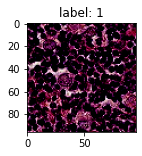

In [42]:
atk_df = train.head(1)
atk_dataset = ImageDataset(df=atk_df, image_dir=train_path, transform=transform)
atk_dataloader = DataLoader(dataset=atk_dataset, batch_size=1, shuffle=False)

image, label = atk_dataset[0]
imshow(image, label)

In [43]:
image, label = iter(atk_dataloader).next() 
image

tensor([[[[-0.6078, -0.4745, -0.2549,  ...,  0.6706, -0.0353, -0.2157],
          [-0.4118, -0.6078, -0.6706,  ..., -0.0118, -0.4039, -0.0588],
          [-0.3725, -0.5843, -0.3882,  ...,  0.3020, -0.3647, -0.1922],
          ...,
          [-0.3961, -0.7569, -0.4039,  ..., -0.3176, -0.3882,  0.6078],
          [-0.0353, -0.2471, -0.6235,  ..., -0.1922, -0.0588,  0.6784],
          [ 0.7333,  0.7882,  0.3961,  ..., -0.0353,  0.0745,  0.4118]],

         [[-0.8902, -0.7569, -0.5137,  ...,  0.2863, -0.4275, -0.5922],
          [-0.6941, -0.8902, -0.9294,  ..., -0.3961, -0.7961, -0.4353],
          [-0.6549, -0.8431, -0.6471,  ..., -0.0980, -0.7569, -0.5686],
          ...,
          [-0.6392, -1.0000, -0.6941,  ..., -0.6627, -0.7098,  0.2863],
          [-0.2941, -0.5451, -0.9529,  ..., -0.5451, -0.4118,  0.3333],
          [ 0.4667,  0.4824,  0.0431,  ..., -0.3961, -0.2863,  0.0588]],

         [[-0.5294, -0.3804, -0.1451,  ...,  0.5373, -0.1373, -0.2784],
          [-0.3176, -0.5137, -

In [44]:
from torchattacks import *

In [45]:
model = modified_Resnet

In [46]:
atks = [
    FGSM(model, eps=0.9),
    BIM(model, eps=0.03, alpha=100, steps=100),
    RFGSM(model, eps=0.3, alpha=2/255, steps=100),
    CW(model, c=1, lr=0.01, steps=100, kappa=0),
    PGD(model, eps=8/255, alpha=2/225, steps=100, random_start=True),
    PGDL2(model, eps=1, alpha=0.2, steps=100),
    EOTPGD(model, eps=8/255, alpha=2/255, steps=100, eot_iter=2),
    FFGSM(model, eps=8/255, alpha=10/255),
    TPGD(model, eps=8/255, alpha=2/255, steps=100),
    MIFGSM(model, eps=8/255, alpha=2/255, steps=100, decay=0.1),
    VANILA(model),
    FAB(model, eps=8/255, steps=100, n_classes=10, n_restarts=1, targeted=False),
    FAB(model, eps=8/255, steps=100, n_classes=10, n_restarts=1, targeted=True),
    Square(model, eps=8/255, n_queries=5000, n_restarts=1, loss='ce'),
    OnePixel(model, pixels=5, inf_batch=50),
    DeepFool(model, steps=100),
    DIFGSM(model, eps=8/255, alpha=2/255, steps=100, diversity_prob=0.5, resize_rate=0.9)
]

In [47]:
def imshow(image, label):
    image = image.cpu()
    label = str(label)
    plt.figure(figsize=(2, 2))
    plt.title("label: " + label)
    image = torch.squeeze(image, 0)
    print(image.shape)
    plt.imshow(image.permute(1, 2, 0))
    plt.show()

----------------------------------------------------------------------
FGSM(model_name=modified_resnet18, device=cuda:0, eps=0.9, attack_mode=default, return_type=float)
torch.Size([3, 96, 96])


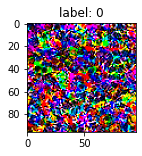

Total elapsed time (sec): 0.15
Robust accuracy: 0.00 %
----------------------------------------------------------------------
BIM(model_name=modified_resnet18, device=cuda:0, eps=0.03, alpha=100, steps=100, attack_mode=default, return_type=float)
torch.Size([3, 96, 96])


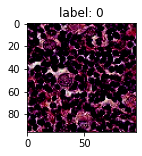

Total elapsed time (sec): 0.96
Robust accuracy: 0.00 %
----------------------------------------------------------------------
RFGSM(model_name=modified_resnet18, device=cuda:0, eps=0.3, alpha=0.00784313725490196, steps=100, attack_mode=default, return_type=float)
torch.Size([3, 96, 96])


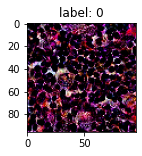

Total elapsed time (sec): 0.94
Robust accuracy: 0.00 %
----------------------------------------------------------------------
CW(model_name=modified_resnet18, device=cuda:0, c=1, kappa=0, steps=100, lr=0.01, attack_mode=default, return_type=float)
torch.Size([3, 96, 96])


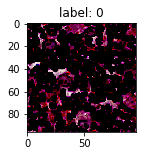

Total elapsed time (sec): 1.15
Robust accuracy: 0.00 %
----------------------------------------------------------------------
PGD(model_name=modified_resnet18, device=cuda:0, eps=0.03137254901960784, alpha=0.008888888888888889, steps=100, random_start=True, attack_mode=default, return_type=float)
torch.Size([3, 96, 96])


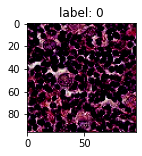

Total elapsed time (sec): 0.92
Robust accuracy: 0.00 %
----------------------------------------------------------------------
PGDL2(model_name=modified_resnet18, device=cuda:0, eps=1, alpha=0.2, steps=100, random_start=True, eps_for_division=1e-10, attack_mode=default, return_type=float)
torch.Size([3, 96, 96])


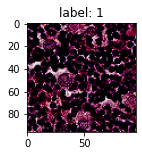

Total elapsed time (sec): 0.93
Robust accuracy: 100.00 %
----------------------------------------------------------------------
EOTPGD(model_name=modified_resnet18, device=cuda:0, eps=0.03137254901960784, alpha=0.00784313725490196, steps=100, eot_iter=2, random_start=True, attack_mode=default, return_type=float)
torch.Size([3, 96, 96])


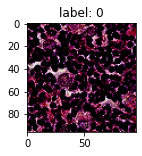

Total elapsed time (sec): 1.72
Robust accuracy: 0.00 %
----------------------------------------------------------------------
FFGSM(model_name=modified_resnet18, device=cuda:0, eps=0.03137254901960784, alpha=0.0392156862745098, attack_mode=default, return_type=float)
torch.Size([3, 96, 96])


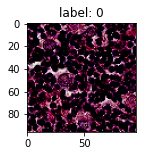

Total elapsed time (sec): 0.14
Robust accuracy: 0.00 %
----------------------------------------------------------------------
TPGD(model_name=modified_resnet18, device=cuda:0, eps=0.03137254901960784, alpha=0.00784313725490196, steps=100, attack_mode=default, return_type=float)
torch.Size([3, 96, 96])


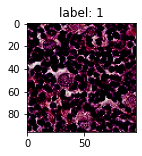

Total elapsed time (sec): 0.93
Robust accuracy: 100.00 %
----------------------------------------------------------------------
MIFGSM(model_name=modified_resnet18, device=cuda:0, eps=0.03137254901960784, steps=100, decay=0.1, alpha=0.00784313725490196, attack_mode=default, return_type=float)
torch.Size([3, 96, 96])


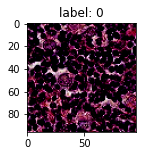

Total elapsed time (sec): 0.92
Robust accuracy: 0.00 %
----------------------------------------------------------------------
VANILA(model_name=modified_resnet18, device=cuda:0, attack_mode=default, return_type=float)
torch.Size([3, 96, 96])


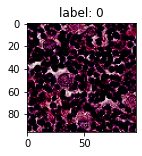

Total elapsed time (sec): 0.14
Robust accuracy: 0.00 %
----------------------------------------------------------------------
FAB(model_name=modified_resnet18, device=cuda:0, norm=Linf, n_restarts=1, eps=0.03137254901960784, alpha_max=0.1, eta=1.05, beta=0.9, steps=100, targeted=False, verbose=False, seed=0, target_class=None, n_target_classes=9, attack_mode=default, return_type=float)
torch.Size([3, 96, 96])


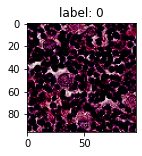

Total elapsed time (sec): 0.14
Robust accuracy: 0.00 %
----------------------------------------------------------------------
FAB(model_name=modified_resnet18, device=cuda:0, norm=Linf, n_restarts=1, eps=0.03137254901960784, alpha_max=0.1, eta=1.05, beta=0.9, steps=100, targeted=False, verbose=False, seed=0, target_class=None, n_target_classes=9, attack_mode=default, return_type=float)
torch.Size([3, 96, 96])


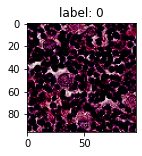

Total elapsed time (sec): 0.14
Robust accuracy: 0.00 %
----------------------------------------------------------------------
Square(model_name=modified_resnet18, device=cuda:0, norm=Linf, n_queries=5000, eps=0.03137254901960784, p_init=0.8, n_restarts=1, seed=0, verbose=False, loss=ce, rescale_schedule=True, attack_mode=default, return_type=float)
torch.Size([3, 96, 96])


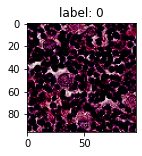

Total elapsed time (sec): 0.15
Robust accuracy: 0.00 %
----------------------------------------------------------------------
OnePixel(model_name=modified_resnet18, device=cuda:0, pixels=5, steps=75, popsize=400, inf_batch=50, attack_mode=default, return_type=float)
torch.Size([3, 96, 96])


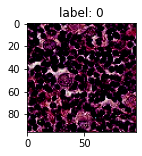

Total elapsed time (sec): 18.13
Robust accuracy: 0.00 %
----------------------------------------------------------------------
DeepFool(model_name=modified_resnet18, device=cuda:0, steps=100, overshoot=0.02, attack_mode=default, return_type=float)
torch.Size([3, 96, 96])


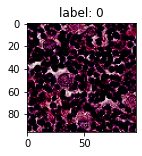

Total elapsed time (sec): 0.17
Robust accuracy: 0.00 %
----------------------------------------------------------------------
DIFGSM(model_name=modified_resnet18, device=cuda:0, eps=0.03137254901960784, steps=100, decay=0.0, alpha=0.00784313725490196, resize_rate=0.9, diversity_prob=0.5, random_start=False, attack_mode=default, return_type=float)
torch.Size([3, 96, 96])


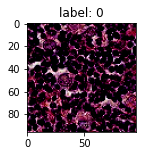

Total elapsed time (sec): 0.95
Robust accuracy: 0.00 %


In [48]:
import time
from tqdm import tqdm

model.eval()
for atk in atks:
    print("-"*70)
    print(atk)
    
    correct = 0
    total = 0
    
    for image, label in atk_dataloader:
        
        start = time.time()
        adv_image = atk(image, label)
        label = label.to(device)
        outputs = model(adv_image)
        
        _,prediction = torch.max(outputs.data, 1)
        
        total += 1
        correct += (prediction == label).sum()
        prediction = prediction.cpu()
        adv_image = adv_image.cpu()
        
        prediction = int(prediction.item())
        imshow(adv_image, prediction)
    
    print("Total elapsed time (sec): %.2f" % (time.time() - start))
    print('Robust accuracy: %.2f %%' % (100 * float(correct) / total))

## Adversarial Training (CW)

### Clean DataLoader

Size of dataset before augment:  176020
torch.Size([3, 96, 96])


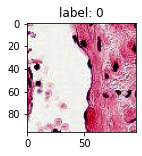

In [49]:
train_path = '../input/cancer-detection/train'

train_img = ImageDataset(df=train, image_dir=train_path, transform=transform)
val_img = ImageDataset(df=val, image_dir=train_path, transform=transform)

batch_train = 512
batch_val = 128

old_train_loader = DataLoader(dataset=train_img, batch_size=batch_train, shuffle=True)
val_loader = DataLoader(dataset=val_img, batch_size=batch_val, shuffle=False)

print("Size of dataset before augment: ", len(train_img))

image, label = train_img[39000]
imshow(image, label)

### 1.1 Normal Training

In [51]:
loss = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 2

print(device)

correct = 0
total = 0

# Normal Training
for epoch in range(num_epochs):
    i = 0
    model.train()
    total_batch = len(train_img) // batch_train
    
    for img, label in tqdm(old_train_loader):
        img, label = img.to(device), label.to(device)

        outputs = model(img)
        cost = loss(outputs, label)

        optimizer.zero_grad()
        cost.backward()
        optimizer.step()
        
        _, predicted = torch.max(outputs.data, 1)
        
        total += label.size(0)
        correct += (predicted == label).sum() 
        i += 1
    
        if (i+1) % 100 == 0:
            print('Train accuracy: %.2f %%' % (100 * float(correct) / total))
            print("Epoch [%d/%d], Iter [%d/%d], Loss: %.4f" % (epoch+1, num_epochs, i+1, total_batch, cost.item()))
        

cuda


 29%|██▉       | 99/344 [01:39<04:25,  1.08s/it]

Train accuracy: 94.67 %
Epoch [1/2], Iter [100/343], Loss: 0.1213


 58%|█████▊    | 199/344 [03:22<02:45,  1.14s/it]

Train accuracy: 94.99 %
Epoch [1/2], Iter [200/343], Loss: 0.1104


 87%|████████▋ | 299/344 [05:05<00:46,  1.04s/it]

Train accuracy: 95.13 %
Epoch [1/2], Iter [300/343], Loss: 0.1458


 29%|██▉       | 99/344 [01:18<03:28,  1.18it/s]

Train accuracy: 95.55 %
Epoch [2/2], Iter [100/343], Loss: 0.0669


 58%|█████▊    | 199/344 [02:38<02:03,  1.17it/s]

Train accuracy: 95.75 %
Epoch [2/2], Iter [200/343], Loss: 0.0638


 87%|████████▋ | 299/344 [03:56<00:36,  1.23it/s]

Train accuracy: 95.88 %
Epoch [2/2], Iter [300/343], Loss: 0.0898


100%|██████████| 344/344 [04:31<00:00,  1.27it/s]


### 1.2 Standard Accuracy

In [ ]:
model.eval()

correct = 0
total = 0

for img, label in tqdm(val_loader):
    img = img.to(device)
    label = label.to(device)

    outputs = model(img)
    cost = loss(outputs, label)

    _, predicted = torch.max(outputs.data, 1)

    total += label.size(0)
    correct += (predicted == label).sum()
    i+=1

    if (i+1) % 100 == 0:
        print('Validation accuracy: %.2f %%' % (100 * float(correct) / total))
        print("Epoch [%d/%d], Iter [%d/%d], Loss: %.4f" % (epoch+1, num_epochs, i+1, total_batch, cost.item()))

### 1.3 Robust Accuracy

In [53]:
# [Validation] Model trained WITH perturbed image
from collections import defaultdict

print("######## Test model trained WITHOUT perturbed images ########")
print("Attack Method: FGSM")

epsilons = [0, .05, .1, .15, .2, .25, .3, .9]

# dict = { eps : [ ... ], 
#          eps : [ ... ] }
eps_accuracy_dict = defaultdict(list)

for eps in epsilons:
    correct = 0
    total = 0
    
    atk = FGSM(model, eps=eps)
    i = 0

    total_batch = len(val_img) // batch_val
    model.eval()
    
    print("")
    print("Epsilon: ", eps)
    for img, label in tqdm(val_loader):
        img, label = img.to(device), label.to(device)

        img = atk(img, label) # FGSM attack

        outputs = model(img)
        cost = loss(outputs, label)

        _, predicted = torch.max(outputs.data, 1)

        total += label.size(0)
        correct += (predicted == label).sum()
        i+=1
        
        # save in dictionary of list
        val_acc = (float(correct) / total) * 100
        # print("val acc: ", val_acc)
        eps_accuracy_dict[eps].append(val_acc)

        if (i+1) % 100 == 0:
            print('Robust accuracy: %.2f %%' % (100 * float(correct) / total))
            print("Epoch [%d/%d], Iter [%d/%d], Loss: %.4f" % (epoch+1, num_epochs, i+1, total_batch, cost.item()))
            print("")

######## Test model trained WITH perturbed images ########
Attack Method: FGSM
Epsilon:  0


 29%|██▉       | 99/344 [01:07<02:57,  1.38it/s]

Robust accuracy: 82.60 %
Epoch [2/2], Iter [100/343], Loss: 0.4465



 58%|█████▊    | 199/344 [02:20<01:47,  1.34it/s]

Robust accuracy: 82.51 %
Epoch [2/2], Iter [200/343], Loss: 0.4653



 87%|████████▋ | 299/344 [03:33<00:32,  1.37it/s]

Robust accuracy: 82.55 %
Epoch [2/2], Iter [300/343], Loss: 0.6371



100%|██████████| 344/344 [04:06<00:00,  1.40it/s]


Epsilon:  0.05


 29%|██▉       | 99/344 [00:25<01:08,  3.55it/s]

Robust accuracy: 40.39 %
Epoch [2/2], Iter [100/343], Loss: 3.0273



 58%|█████▊    | 199/344 [00:51<00:37,  3.92it/s]

Robust accuracy: 40.46 %
Epoch [2/2], Iter [200/343], Loss: 2.8283



 87%|████████▋ | 299/344 [01:17<00:11,  4.09it/s]

Robust accuracy: 40.48 %
Epoch [2/2], Iter [300/343], Loss: 2.7361



100%|██████████| 344/344 [01:28<00:00,  3.89it/s]


Epsilon:  0.1


 29%|██▉       | 99/344 [00:25<01:04,  3.79it/s]

Robust accuracy: 37.41 %
Epoch [2/2], Iter [100/343], Loss: 2.7002



 58%|█████▊    | 199/344 [00:50<00:36,  4.00it/s]

Robust accuracy: 37.08 %
Epoch [2/2], Iter [200/343], Loss: 2.6009



 87%|████████▋ | 299/344 [01:16<00:11,  4.07it/s]

Robust accuracy: 37.25 %
Epoch [2/2], Iter [300/343], Loss: 2.3881



100%|██████████| 344/344 [01:27<00:00,  3.92it/s]


Epsilon:  0.15


 29%|██▉       | 99/344 [00:25<01:07,  3.63it/s]

Robust accuracy: 40.01 %
Epoch [2/2], Iter [100/343], Loss: 2.1600



 58%|█████▊    | 199/344 [00:51<00:37,  3.90it/s]

Robust accuracy: 40.13 %
Epoch [2/2], Iter [200/343], Loss: 2.1945



 87%|████████▋ | 299/344 [01:16<00:11,  3.94it/s]

Robust accuracy: 40.19 %
Epoch [2/2], Iter [300/343], Loss: 2.0229



100%|██████████| 344/344 [01:28<00:00,  3.90it/s]


Epsilon:  0.2


 29%|██▉       | 99/344 [00:25<01:10,  3.46it/s]

Robust accuracy: 44.55 %
Epoch [2/2], Iter [100/343], Loss: 1.8468



 58%|█████▊    | 199/344 [00:51<00:36,  3.94it/s]

Robust accuracy: 44.62 %
Epoch [2/2], Iter [200/343], Loss: 1.9087



 87%|████████▋ | 299/344 [01:17<00:11,  3.92it/s]

Robust accuracy: 44.71 %
Epoch [2/2], Iter [300/343], Loss: 1.8066



100%|██████████| 344/344 [01:28<00:00,  3.87it/s]


Epsilon:  0.25


 29%|██▉       | 99/344 [00:25<01:03,  3.88it/s]

Robust accuracy: 48.22 %
Epoch [2/2], Iter [100/343], Loss: 1.7235



 58%|█████▊    | 199/344 [00:51<00:36,  4.02it/s]

Robust accuracy: 48.48 %
Epoch [2/2], Iter [200/343], Loss: 1.7613



 87%|████████▋ | 299/344 [01:17<00:11,  3.93it/s]

Robust accuracy: 48.72 %
Epoch [2/2], Iter [300/343], Loss: 1.7061



100%|██████████| 344/344 [01:28<00:00,  3.89it/s]


Epsilon:  0.3


 29%|██▉       | 99/344 [00:25<01:03,  3.88it/s]

Robust accuracy: 51.05 %
Epoch [2/2], Iter [100/343], Loss: 1.7295



 58%|█████▊    | 199/344 [00:51<00:36,  3.97it/s]

Robust accuracy: 51.18 %
Epoch [2/2], Iter [200/343], Loss: 1.8719



 87%|████████▋ | 299/344 [01:16<00:11,  4.00it/s]

Robust accuracy: 51.47 %
Epoch [2/2], Iter [300/343], Loss: 1.7562



100%|██████████| 344/344 [01:27<00:00,  3.91it/s]


Epsilon:  0.9


 29%|██▉       | 99/344 [00:26<01:10,  3.50it/s]

Robust accuracy: 59.52 %
Epoch [2/2], Iter [100/343], Loss: 3.7219



 58%|█████▊    | 199/344 [00:53<00:38,  3.72it/s]

Robust accuracy: 59.29 %
Epoch [2/2], Iter [200/343], Loss: 4.0422



 87%|████████▋ | 299/344 [01:20<00:12,  3.54it/s]

Robust accuracy: 59.50 %
Epoch [2/2], Iter [300/343], Loss: 4.2618



100%|██████████| 344/344 [01:32<00:00,  3.70it/s]


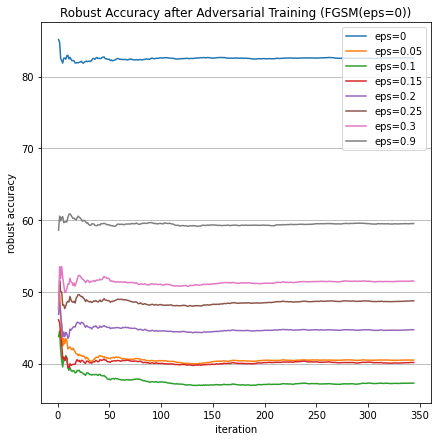

In [76]:
import matplotlib.pyplot as plt

iteration = list(range(1, len(eps_accuracy_dict[0])+1))

plt.figure(figsize=(7, 7))
plt.grid(axis='y')
plt.title("Robust Accuracy after Adversarial Training (FGSM(eps=0))")
plt.xlabel("Iteration")
plt.ylabel("Robust Accuracy(%)")

for eps in epsilons:
    plt.plot(iteration, eps_accuracy_dict[eps], label=("eps={}".format(eps)))
    plt.legend()

## 1. Adversarial Training (FGSM eps=0.05)

In [77]:
# Randomly choose one attack method from the list
# Train with that image (in addition to the model trained with original image)

loss = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 2

print("Training WITH attacked images (FGSM eps=0.05)")
print(device)

correct = 0
total = 0

atk = FGSM(model, eps=0.05)

for epoch in range(num_epochs):
    i = 0
    model.train()
    total_batch = len(train_img) // batch_train
    
    for img, label in tqdm(old_train_loader):
        img, label = img.to(device), label.to(device)
        
        # Attack
        # atk = random.choice(atks) # randomly choose an attack method from the list        
        img = atk(img, label) # create attack image

        outputs = model(img)
        cost = loss(outputs, label)

        optimizer.zero_grad()
        cost.backward()
        optimizer.step()

        _, predicted = torch.max(outputs.data, 1)

        total += label.size(0)
        correct += (predicted == label).sum() 
        i += 1
        
        if (i+1) % 100 == 0:
            print('Train accuracy: %.2f %%' % (100 * float(correct) / total))
            print("Epoch [%d/%d], Iter [%d/%d]" % (epoch+1, num_epochs, i+1, total_batch))
        
        

Training WITH attacked images (FGSM eps=0.05)
cuda


 29%|██▉       | 99/344 [01:49<04:52,  1.19s/it]

Train accuracy: 75.59 %
Epoch [1/2], Iter [100/343]


 58%|█████▊    | 199/344 [03:44<03:00,  1.24s/it]

Train accuracy: 77.32 %
Epoch [1/2], Iter [200/343]


 87%|████████▋ | 299/344 [05:39<00:56,  1.24s/it]

Train accuracy: 76.66 %
Epoch [1/2], Iter [300/343]


 29%|██▉       | 99/344 [01:27<04:07,  1.01s/it]

Train accuracy: 75.87 %
Epoch [2/2], Iter [100/343]


 58%|█████▊    | 199/344 [02:55<02:13,  1.09it/s]

Train accuracy: 76.70 %
Epoch [2/2], Iter [200/343]


 87%|████████▋ | 299/344 [04:23<00:43,  1.03it/s]

Train accuracy: 77.07 %
Epoch [2/2], Iter [300/343]


100%|██████████| 344/344 [05:03<00:00,  1.13it/s]


## Adversarial Validation

In [78]:
# [Validation] Model trained WITH perturbed image
from collections import defaultdict

print("######## Test model trained WITH FGSM (eps=0.05) ########")
print("Attack Method: FGSM")

epsilons = [0, .05, .1, .15, .2, .25, .3, .9]

# dict = { eps : [ ... ], 
#          eps : [ ... ] }
eps_accuracy_dict = defaultdict(list)

for eps in epsilons:
    correct = 0
    total = 0
    
    atk = FGSM(model, eps=eps)
    i = 0

    total_batch = len(val_img) // batch_val
    model.eval()
    
    print("")
    print("Epsilon: ", eps)
    for img, label in tqdm(val_loader):
        img, label = img.to(device), label.to(device)

        img = atk(img, label) # FGSM attack

        outputs = model(img)
        cost = loss(outputs, label)

        _, predicted = torch.max(outputs.data, 1)

        total += label.size(0)
        correct += (predicted == label).sum()
        i+=1
        
        # save in dictionary of list
        val_acc = (float(correct) / total) * 100
        # print("val acc: ", val_acc)
        eps_accuracy_dict[eps].append(val_acc)

        if (i+1) % 100 == 0:
            print('Robust accuracy: %.2f %%' % (100 * float(correct) / total))
            print("Epoch [%d/%d], Iter [%d/%d], Loss: %.4f" % (epoch+1, num_epochs, i+1, total_batch, cost.item()))
            print("")

######## Test model trained WITH FGSM (eps=0.05) ########
Attack Method: FGSM

Epsilon:  0


 29%|██▉       | 99/344 [00:38<01:37,  2.52it/s]

Robust accuracy: 75.84 %
Epoch [2/2], Iter [100/343], Loss: 0.5470



 58%|█████▊    | 199/344 [01:16<00:54,  2.68it/s]

Robust accuracy: 75.67 %
Epoch [2/2], Iter [200/343], Loss: 0.5012



 87%|████████▋ | 299/344 [01:53<00:16,  2.69it/s]

Robust accuracy: 75.69 %
Epoch [2/2], Iter [300/343], Loss: 0.7778



100%|██████████| 344/344 [02:11<00:00,  2.62it/s]



Epsilon:  0.05


 29%|██▉       | 99/344 [00:25<01:02,  3.93it/s]

Robust accuracy: 93.47 %
Epoch [2/2], Iter [100/343], Loss: 0.1629



 58%|█████▊    | 199/344 [00:50<00:36,  3.98it/s]

Robust accuracy: 93.32 %
Epoch [2/2], Iter [200/343], Loss: 0.1261



 87%|████████▋ | 299/344 [01:16<00:11,  3.96it/s]

Robust accuracy: 93.39 %
Epoch [2/2], Iter [300/343], Loss: 0.1875



100%|██████████| 344/344 [01:28<00:00,  3.90it/s]



Epsilon:  0.1


 29%|██▉       | 99/344 [00:24<01:00,  4.07it/s]

Robust accuracy: 81.84 %
Epoch [2/2], Iter [100/343], Loss: 0.4936



 58%|█████▊    | 199/344 [00:49<00:35,  4.08it/s]

Robust accuracy: 82.00 %
Epoch [2/2], Iter [200/343], Loss: 0.2923



 87%|████████▋ | 299/344 [01:15<00:11,  4.01it/s]

Robust accuracy: 82.01 %
Epoch [2/2], Iter [300/343], Loss: 0.5161



100%|██████████| 344/344 [01:26<00:00,  3.98it/s]



Epsilon:  0.15


 29%|██▉       | 99/344 [00:24<00:59,  4.11it/s]

Robust accuracy: 66.05 %
Epoch [2/2], Iter [100/343], Loss: 1.0514



 58%|█████▊    | 199/344 [00:49<00:35,  4.12it/s]

Robust accuracy: 66.37 %
Epoch [2/2], Iter [200/343], Loss: 0.7453



 87%|████████▋ | 299/344 [01:15<00:16,  2.77it/s]

Robust accuracy: 66.42 %
Epoch [2/2], Iter [300/343], Loss: 1.2703



100%|██████████| 344/344 [01:26<00:00,  3.98it/s]



Epsilon:  0.2


 29%|██▉       | 99/344 [00:24<01:03,  3.88it/s]

Robust accuracy: 56.18 %
Epoch [2/2], Iter [100/343], Loss: 1.5331



 58%|█████▊    | 199/344 [00:49<00:35,  4.09it/s]

Robust accuracy: 56.56 %
Epoch [2/2], Iter [200/343], Loss: 1.2859



 87%|████████▋ | 299/344 [01:15<00:11,  3.97it/s]

Robust accuracy: 56.55 %
Epoch [2/2], Iter [300/343], Loss: 1.9087



100%|██████████| 344/344 [01:26<00:00,  3.99it/s]



Epsilon:  0.25


 29%|██▉       | 99/344 [00:25<01:00,  4.06it/s]

Robust accuracy: 50.24 %
Epoch [2/2], Iter [100/343], Loss: 2.1205



 58%|█████▊    | 199/344 [00:50<00:35,  4.12it/s]

Robust accuracy: 50.10 %
Epoch [2/2], Iter [200/343], Loss: 1.9694



 87%|████████▋ | 299/344 [01:15<00:11,  4.09it/s]

Robust accuracy: 49.93 %
Epoch [2/2], Iter [300/343], Loss: 2.3839



100%|██████████| 344/344 [01:27<00:00,  3.95it/s]



Epsilon:  0.3


 29%|██▉       | 99/344 [00:25<01:02,  3.89it/s]

Robust accuracy: 46.39 %
Epoch [2/2], Iter [100/343], Loss: 2.6510



 58%|█████▊    | 199/344 [00:50<00:35,  4.06it/s]

Robust accuracy: 46.15 %
Epoch [2/2], Iter [200/343], Loss: 2.5608



 87%|████████▋ | 299/344 [01:15<00:10,  4.12it/s]

Robust accuracy: 45.97 %
Epoch [2/2], Iter [300/343], Loss: 2.6633



100%|██████████| 344/344 [01:26<00:00,  3.97it/s]



Epsilon:  0.9


 29%|██▉       | 99/344 [00:25<01:11,  3.43it/s]

Robust accuracy: 59.82 %
Epoch [2/2], Iter [100/343], Loss: 2.5053



 58%|█████▊    | 199/344 [00:50<00:35,  4.07it/s]

Robust accuracy: 59.54 %
Epoch [2/2], Iter [200/343], Loss: 2.7447



 87%|████████▋ | 299/344 [01:15<00:11,  3.95it/s]

Robust accuracy: 59.81 %
Epoch [2/2], Iter [300/343], Loss: 2.8174



100%|██████████| 344/344 [01:27<00:00,  3.95it/s]


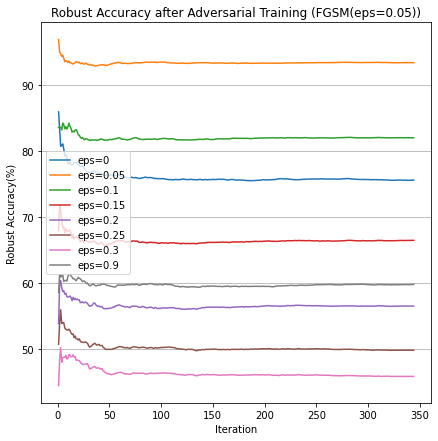

In [84]:
import matplotlib.pyplot as plt

iteration = list(range(1, len(eps_accuracy_dict[0])+1))

plt.figure(figsize=(7, 7))
plt.grid(axis='y')
plt.title("Robust Accuracy after Adversarial Training (FGSM(eps=0.05))")
plt.xlabel("Iteration")
plt.ylabel("Robust Accuracy(%)")


for eps in epsilons:
    plt.plot(iteration, eps_accuracy_dict[eps], label=("eps={}".format(eps)))
    plt.legend()

## 2. Adversarial Training (FGSM eps=0.1)

In [85]:
# Randomly choose one attack method from the list
# Train with that image (in addition to the model trained with original image)

loss = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 2

print("Training WITH adversarial examples (FGSM eps=0.1)")
print(device)

correct = 0
total = 0

atk = FGSM(model, eps=0.1)

for epoch in range(num_epochs):
    i = 0
    model.train()
    total_batch = len(train_img) // batch_train
    
    for img, label in tqdm(old_train_loader):
        img, label = img.to(device), label.to(device)
        
        # Attack
        # atk = random.choice(atks) # randomly choose an attack method from the list        
        img = atk(img, label) # create attack image

        outputs = model(img)
        cost = loss(outputs, label)

        optimizer.zero_grad()
        cost.backward()
        optimizer.step()

        _, predicted = torch.max(outputs.data, 1)

        total += label.size(0)
        correct += (predicted == label).sum() 
        i += 1
        
        if (i+1) % 100 == 0:
            print('Train accuracy: %.2f %%' % (100 * float(correct) / total))
            print("Epoch [%d/%d], Iter [%d/%d]" % (epoch+1, num_epochs, i+1, total_batch))
        
        

Training WITH adversarial examples (FGSM eps=0.1)
cuda


 29%|██▉       | 99/344 [01:28<03:49,  1.07it/s]

Train accuracy: 79.32 %
Epoch [1/2], Iter [100/343]


 58%|█████▊    | 199/344 [02:57<02:20,  1.03it/s]

Train accuracy: 81.87 %
Epoch [1/2], Iter [200/343]


 87%|████████▋ | 299/344 [04:26<00:43,  1.04it/s]

Train accuracy: 82.05 %
Epoch [1/2], Iter [300/343]


 29%|██▉       | 99/344 [01:25<03:51,  1.06it/s]

Train accuracy: 78.96 %
Epoch [2/2], Iter [100/343]


 58%|█████▊    | 199/344 [02:52<02:17,  1.05it/s]

Train accuracy: 79.90 %
Epoch [2/2], Iter [200/343]


 87%|████████▋ | 299/344 [04:18<00:43,  1.04it/s]

Train accuracy: 81.28 %
Epoch [2/2], Iter [300/343]


100%|██████████| 344/344 [04:56<00:00,  1.16it/s]


In [86]:
# [Validation] Model trained WITH perturbed image
from collections import defaultdict

print("######## Test model trained WITH FGSM (eps=0.1) ########")
print("Attack Method: FGSM")

epsilons = [0, .05, .1, .15, .2, .25, .3, .9]

# dict = { eps : [ ... ], 
#          eps : [ ... ] }
eps_accuracy_dict = defaultdict(list)

for eps in epsilons:
    correct = 0
    total = 0
    
    atk = FGSM(model, eps=eps)
    i = 0

    total_batch = len(val_img) // batch_val
    model.eval()
    
    print("")
    print("Epsilon: ", eps)
    for img, label in tqdm(val_loader):
        img, label = img.to(device), label.to(device)

        img = atk(img, label) # FGSM attack

        outputs = model(img)
        cost = loss(outputs, label)

        _, predicted = torch.max(outputs.data, 1)

        total += label.size(0)
        correct += (predicted == label).sum()
        i+=1
        
        # save in dictionary of list
        val_acc = (float(correct) / total) * 100
        # print("val acc: ", val_acc)
        eps_accuracy_dict[eps].append(val_acc)

        if (i+1) % 100 == 0:
            print('Robust accuracy: %.2f %%' % (100 * float(correct) / total))
            print("Epoch [%d/%d], Iter [%d/%d], Loss: %.4f" % (epoch+1, num_epochs, i+1, total_batch, cost.item()))
            print("")

######## Test model trained WITH FGSM (eps=0.1) ########
Attack Method: FGSM

Epsilon:  0


 29%|██▉       | 99/344 [00:24<01:00,  4.06it/s]

Robust accuracy: 64.17 %
Epoch [2/2], Iter [100/343], Loss: 1.2939



 58%|█████▊    | 199/344 [00:49<00:34,  4.15it/s]

Robust accuracy: 64.28 %
Epoch [2/2], Iter [200/343], Loss: 1.4553



 87%|████████▋ | 299/344 [01:13<00:11,  3.91it/s]

Robust accuracy: 64.28 %
Epoch [2/2], Iter [300/343], Loss: 1.3082



100%|██████████| 344/344 [01:24<00:00,  4.05it/s]



Epsilon:  0.05


 29%|██▉       | 99/344 [00:25<00:59,  4.10it/s]

Robust accuracy: 82.58 %
Epoch [2/2], Iter [100/343], Loss: 0.4452



 58%|█████▊    | 199/344 [00:50<00:35,  4.07it/s]

Robust accuracy: 82.41 %
Epoch [2/2], Iter [200/343], Loss: 0.4006



 87%|████████▋ | 299/344 [01:14<00:11,  4.09it/s]

Robust accuracy: 82.42 %
Epoch [2/2], Iter [300/343], Loss: 0.4340



100%|██████████| 344/344 [01:26<00:00,  3.99it/s]



Epsilon:  0.1


 29%|██▉       | 99/344 [00:24<01:04,  3.80it/s]

Robust accuracy: 89.13 %
Epoch [2/2], Iter [100/343], Loss: 0.1727



 58%|█████▊    | 199/344 [00:49<00:35,  4.14it/s]

Robust accuracy: 88.97 %
Epoch [2/2], Iter [200/343], Loss: 0.2185



 87%|████████▋ | 299/344 [01:13<00:10,  4.16it/s]

Robust accuracy: 88.99 %
Epoch [2/2], Iter [300/343], Loss: 0.2448



100%|██████████| 344/344 [01:24<00:00,  4.05it/s]



Epsilon:  0.15


 29%|██▉       | 99/344 [00:24<00:58,  4.15it/s]

Robust accuracy: 74.42 %
Epoch [2/2], Iter [100/343], Loss: 0.6787



 58%|█████▊    | 199/344 [00:49<00:35,  4.03it/s]

Robust accuracy: 74.49 %
Epoch [2/2], Iter [200/343], Loss: 0.6326



 87%|████████▋ | 299/344 [01:14<00:10,  4.12it/s]

Robust accuracy: 74.43 %
Epoch [2/2], Iter [300/343], Loss: 0.8579



100%|██████████| 344/344 [01:25<00:00,  4.04it/s]



Epsilon:  0.2


 29%|██▉       | 99/344 [00:24<00:59,  4.11it/s]

Robust accuracy: 70.94 %
Epoch [2/2], Iter [100/343], Loss: 1.0917



 58%|█████▊    | 199/344 [00:49<00:36,  3.98it/s]

Robust accuracy: 70.96 %
Epoch [2/2], Iter [200/343], Loss: 1.1037



 87%|████████▋ | 299/344 [01:15<00:11,  3.82it/s]

Robust accuracy: 70.93 %
Epoch [2/2], Iter [300/343], Loss: 1.2055



100%|██████████| 344/344 [01:26<00:00,  3.97it/s]



Epsilon:  0.25


 29%|██▉       | 99/344 [00:24<00:59,  4.13it/s]

Robust accuracy: 59.90 %
Epoch [2/2], Iter [100/343], Loss: 1.4881



 58%|█████▊    | 199/344 [00:49<00:36,  3.98it/s]

Robust accuracy: 59.87 %
Epoch [2/2], Iter [200/343], Loss: 1.6672



 87%|████████▋ | 299/344 [01:14<00:11,  3.80it/s]

Robust accuracy: 59.72 %
Epoch [2/2], Iter [300/343], Loss: 1.5906



100%|██████████| 344/344 [01:25<00:00,  4.00it/s]



Epsilon:  0.3


 29%|██▉       | 99/344 [00:25<01:01,  3.97it/s]

Robust accuracy: 42.77 %
Epoch [2/2], Iter [100/343], Loss: 2.1690



 58%|█████▊    | 199/344 [00:50<00:35,  4.04it/s]

Robust accuracy: 42.92 %
Epoch [2/2], Iter [200/343], Loss: 2.4844



 87%|████████▋ | 299/344 [01:15<00:10,  4.11it/s]

Robust accuracy: 42.67 %
Epoch [2/2], Iter [300/343], Loss: 2.2368



100%|██████████| 344/344 [01:26<00:00,  3.96it/s]



Epsilon:  0.9


 29%|██▉       | 99/344 [00:24<01:01,  3.99it/s]

Robust accuracy: 32.64 %
Epoch [2/2], Iter [100/343], Loss: 12.3721



 58%|█████▊    | 199/344 [00:49<00:34,  4.16it/s]

Robust accuracy: 32.69 %
Epoch [2/2], Iter [200/343], Loss: 11.3064



 87%|████████▋ | 299/344 [01:14<00:10,  4.15it/s]

Robust accuracy: 32.52 %
Epoch [2/2], Iter [300/343], Loss: 10.8515



100%|██████████| 344/344 [01:25<00:00,  4.04it/s]


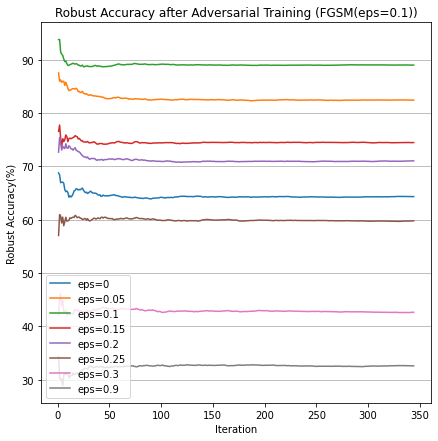

In [87]:
import matplotlib.pyplot as plt

iteration = list(range(1, len(eps_accuracy_dict[0])+1))

plt.figure(figsize=(7, 7))
plt.grid(axis='y')
plt.title("Robust Accuracy after Adversarial Training (FGSM(eps=0.1))")
plt.xlabel("Iteration")
plt.ylabel("Robust Accuracy(%)")

for eps in epsilons:
    plt.plot(iteration, eps_accuracy_dict[eps], label=("eps={}".format(eps)))
    plt.legend()

## 3. Adversarial Training (FGSM eps=0.9)

In [88]:
# Randomly choose one attack method from the list
# Train with that image (in addition to the model trained with original image)

loss = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 2

print("Training WITH attacked images")
print(device)

correct = 0
total = 0

atk = FGSM(model, eps=0.9)

for epoch in range(num_epochs):
    i = 0
    model.train()
    total_batch = len(train_img) // batch_train
    
    for img, label in tqdm(old_train_loader):
        img, label = img.to(device), label.to(device)
        
        # Attack
        # atk = random.choice(atks) # randomly choose an attack method from the list        
        img = atk(img, label) # create attack image

        outputs = model(img)
        cost = loss(outputs, label)

        optimizer.zero_grad()
        cost.backward()
        optimizer.step()

        _, predicted = torch.max(outputs.data, 1)

        total += label.size(0)
        correct += (predicted == label).sum() 
        i += 1
        
        if (i+1) % 100 == 0:
            print('Train accuracy: %.2f %%' % (100 * float(correct) / total))
            print("Epoch [%d/%d], Iter [%d/%d]" % (epoch+1, num_epochs, i+1, total_batch))
        
        

Training WITH attacked images
cuda


 29%|██▉       | 99/344 [01:26<03:47,  1.08it/s]

Train accuracy: 79.97 %
Epoch [1/2], Iter [100/343]


 58%|█████▊    | 199/344 [02:53<02:20,  1.03it/s]

Train accuracy: 77.94 %
Epoch [1/2], Iter [200/343]


 87%|████████▋ | 299/344 [04:19<00:43,  1.03it/s]

Train accuracy: 79.56 %
Epoch [1/2], Iter [300/343]


 29%|██▉       | 99/344 [01:28<04:03,  1.00it/s]

Train accuracy: 76.76 %
Epoch [2/2], Iter [100/343]


 58%|█████▊    | 199/344 [02:57<02:16,  1.06it/s]

Train accuracy: 74.35 %
Epoch [2/2], Iter [200/343]


 87%|████████▋ | 299/344 [04:26<00:44,  1.02it/s]

Train accuracy: 72.80 %
Epoch [2/2], Iter [300/343]


100%|██████████| 344/344 [05:06<00:00,  1.12it/s]


In [89]:
# [Validation] Model trained WITH perturbed image
from collections import defaultdict

print("######## Test model trained WITH FGSM (eps=0.9) ########")
print("Attack Method: FGSM")

epsilons = [0, .05, .1, .15, .2, .25, .3, .9]

# dict = { eps : [ ... ], 
#          eps : [ ... ] }
eps_accuracy_dict = defaultdict(list)

for eps in epsilons:
    correct = 0
    total = 0
    
    atk = FGSM(model, eps=eps)
    i = 0

    total_batch = len(val_img) // batch_val
    model.eval()
    
    print("")
    print("Epsilon: ", eps)
    for img, label in tqdm(val_loader):
        img, label = img.to(device), label.to(device)

        img = atk(img, label) # FGSM attack

        outputs = model(img)
        cost = loss(outputs, label)

        _, predicted = torch.max(outputs.data, 1)

        total += label.size(0)
        correct += (predicted == label).sum()
        i+=1
        
        # save in dictionary of list
        val_acc = (float(correct) / total) * 100
        # print("val acc: ", val_acc)
        eps_accuracy_dict[eps].append(val_acc)

        if (i+1) % 100 == 0:
            print('Robust accuracy: %.2f %%' % (100 * float(correct) / total))
            print("Epoch [%d/%d], Iter [%d/%d], Loss: %.4f" % (epoch+1, num_epochs, i+1, total_batch, cost.item()))
            print("")

######## Test model trained WITH FGSM (eps=0.9) ########
Attack Method: FGSM

Epsilon:  0


 29%|██▉       | 99/344 [00:25<01:05,  3.73it/s]

Robust accuracy: 41.53 %
Epoch [2/2], Iter [100/343], Loss: 0.6945



 58%|█████▊    | 199/344 [00:50<00:36,  4.02it/s]

Robust accuracy: 41.86 %
Epoch [2/2], Iter [200/343], Loss: 0.6949



 87%|████████▋ | 299/344 [01:15<00:11,  4.03it/s]

Robust accuracy: 41.60 %
Epoch [2/2], Iter [300/343], Loss: 0.6938



100%|██████████| 344/344 [01:26<00:00,  3.96it/s]



Epsilon:  0.05


 29%|██▉       | 99/344 [00:24<01:03,  3.83it/s]

Robust accuracy: 40.74 %
Epoch [2/2], Iter [100/343], Loss: 0.6933



 58%|█████▊    | 199/344 [00:49<00:35,  4.05it/s]

Robust accuracy: 40.97 %
Epoch [2/2], Iter [200/343], Loss: 0.6941



 87%|████████▋ | 299/344 [01:15<00:11,  3.86it/s]

Robust accuracy: 40.73 %
Epoch [2/2], Iter [300/343], Loss: 0.6932



100%|██████████| 344/344 [01:27<00:00,  3.95it/s]



Epsilon:  0.1


 29%|██▉       | 99/344 [00:26<01:05,  3.74it/s]

Robust accuracy: 39.74 %
Epoch [2/2], Iter [100/343], Loss: 0.6926



 58%|█████▊    | 199/344 [00:53<00:38,  3.77it/s]

Robust accuracy: 39.82 %
Epoch [2/2], Iter [200/343], Loss: 0.6932



 87%|████████▋ | 299/344 [01:19<00:12,  3.50it/s]

Robust accuracy: 39.61 %
Epoch [2/2], Iter [300/343], Loss: 0.6929



100%|██████████| 344/344 [01:31<00:00,  3.75it/s]



Epsilon:  0.15


 29%|██▉       | 99/344 [00:25<01:00,  4.06it/s]

Robust accuracy: 38.20 %
Epoch [2/2], Iter [100/343], Loss: 0.6936



 58%|█████▊    | 199/344 [00:49<00:35,  4.14it/s]

Robust accuracy: 38.31 %
Epoch [2/2], Iter [200/343], Loss: 0.6926



 87%|████████▋ | 299/344 [01:15<00:11,  4.08it/s]

Robust accuracy: 38.18 %
Epoch [2/2], Iter [300/343], Loss: 0.6932



100%|██████████| 344/344 [01:26<00:00,  3.99it/s]



Epsilon:  0.2


 29%|██▉       | 99/344 [00:24<00:59,  4.09it/s]

Robust accuracy: 36.14 %
Epoch [2/2], Iter [100/343], Loss: 0.6961



 58%|█████▊    | 199/344 [00:49<00:36,  4.02it/s]

Robust accuracy: 36.27 %
Epoch [2/2], Iter [200/343], Loss: 0.6931



 87%|████████▋ | 299/344 [01:14<00:10,  4.15it/s]

Robust accuracy: 36.07 %
Epoch [2/2], Iter [300/343], Loss: 0.6944



100%|██████████| 344/344 [01:26<00:00,  3.99it/s]



Epsilon:  0.25


 29%|██▉       | 99/344 [00:25<01:04,  3.79it/s]

Robust accuracy: 33.33 %
Epoch [2/2], Iter [100/343], Loss: 0.6984



 58%|█████▊    | 199/344 [00:49<00:35,  4.05it/s]

Robust accuracy: 33.41 %
Epoch [2/2], Iter [200/343], Loss: 0.6946



 87%|████████▋ | 299/344 [01:14<00:10,  4.16it/s]

Robust accuracy: 33.20 %
Epoch [2/2], Iter [300/343], Loss: 0.6963



100%|██████████| 344/344 [01:25<00:00,  4.00it/s]



Epsilon:  0.3


 29%|██▉       | 99/344 [00:24<01:00,  4.02it/s]

Robust accuracy: 30.57 %
Epoch [2/2], Iter [100/343], Loss: 0.6995



 58%|█████▊    | 199/344 [00:49<00:37,  3.90it/s]

Robust accuracy: 30.59 %
Epoch [2/2], Iter [200/343], Loss: 0.6962



 87%|████████▋ | 299/344 [01:14<00:11,  4.07it/s]

Robust accuracy: 30.36 %
Epoch [2/2], Iter [300/343], Loss: 0.6981



100%|██████████| 344/344 [01:25<00:00,  4.02it/s]



Epsilon:  0.9


 29%|██▉       | 99/344 [00:24<01:00,  4.08it/s]

Robust accuracy: 55.71 %
Epoch [2/2], Iter [100/343], Loss: 0.6680



 58%|█████▊    | 199/344 [00:49<00:35,  4.06it/s]

Robust accuracy: 55.58 %
Epoch [2/2], Iter [200/343], Loss: 0.6579



 87%|████████▋ | 299/344 [01:15<00:12,  3.69it/s]

Robust accuracy: 55.57 %
Epoch [2/2], Iter [300/343], Loss: 0.6699



100%|██████████| 344/344 [01:27<00:00,  3.95it/s]


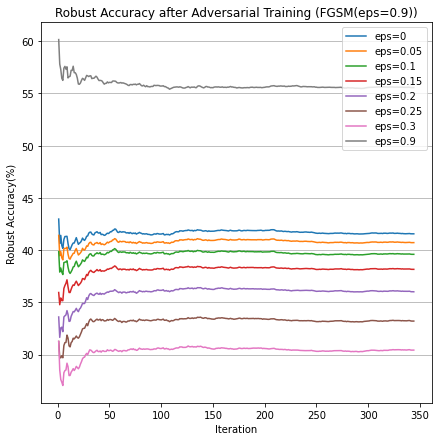

In [90]:
import matplotlib.pyplot as plt

iteration = list(range(1, len(eps_accuracy_dict[0])+1))

plt.figure(figsize=(7, 7))
plt.grid(axis='y')
plt.title("Robust Accuracy after Adversarial Training (FGSM(eps=0.9))")
plt.xlabel("Iteration")
plt.ylabel("Robust Accuracy(%)")

for eps in epsilons:
    plt.plot(iteration, eps_accuracy_dict[eps], label=("eps={}".format(eps)))
    plt.legend()